## 3-Way ANOVA

The three-way ANOVA is an extension of the two-way ANOVA for assessing whether there is an interaction effect between three independent categorical variables on a continuous outcome variable.

We’ll use the **headache dataset**, which contains the measures of migraine headache episode pain score in 72 participants treated with three different treatments. The participants include 36 males and 36 females. Males and females were further subdivided into whether they were at low or high risk of migraine.

We want to understand how each independent variable (type of treatments, risk of migraine and gender) interact to predict the pain score.

In [8]:
import pandas as pd

# URL to the CSV file
url = "https://github.com/kflisikowski/ds/raw/master/headache.csv"

# Load the data into a DataFrame
headache = pd.read_csv(url)

# Display the first few rows of the data
print(headache.head())

   id gender risk treatment  pain_score
0   1   male  low         X   79.311695
1   2   male  low         X   76.843399
2   3   male  low         X   70.832421
3   4   male  low         X   81.163944
4   5   male  low         X   75.052213


## Descriptive statistics

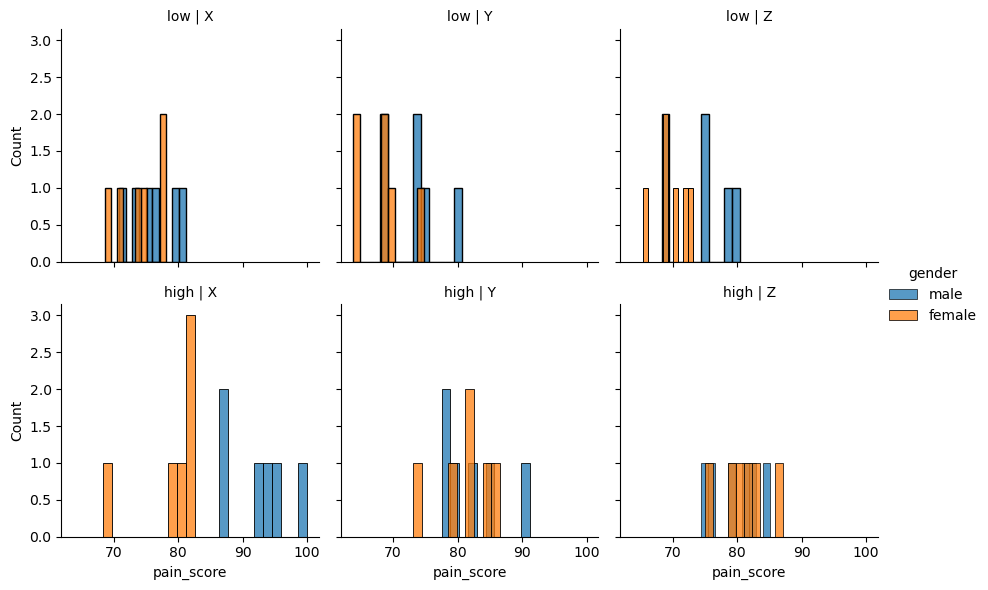

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# firstly plot the data
g = sns.FacetGrid(headache, col='treatment', row='risk', hue='gender')
g.map_dataframe(sns.histplot, x='pain_score', bins=10)
g.add_legend()
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.show()


It is worth to vizualize the means now

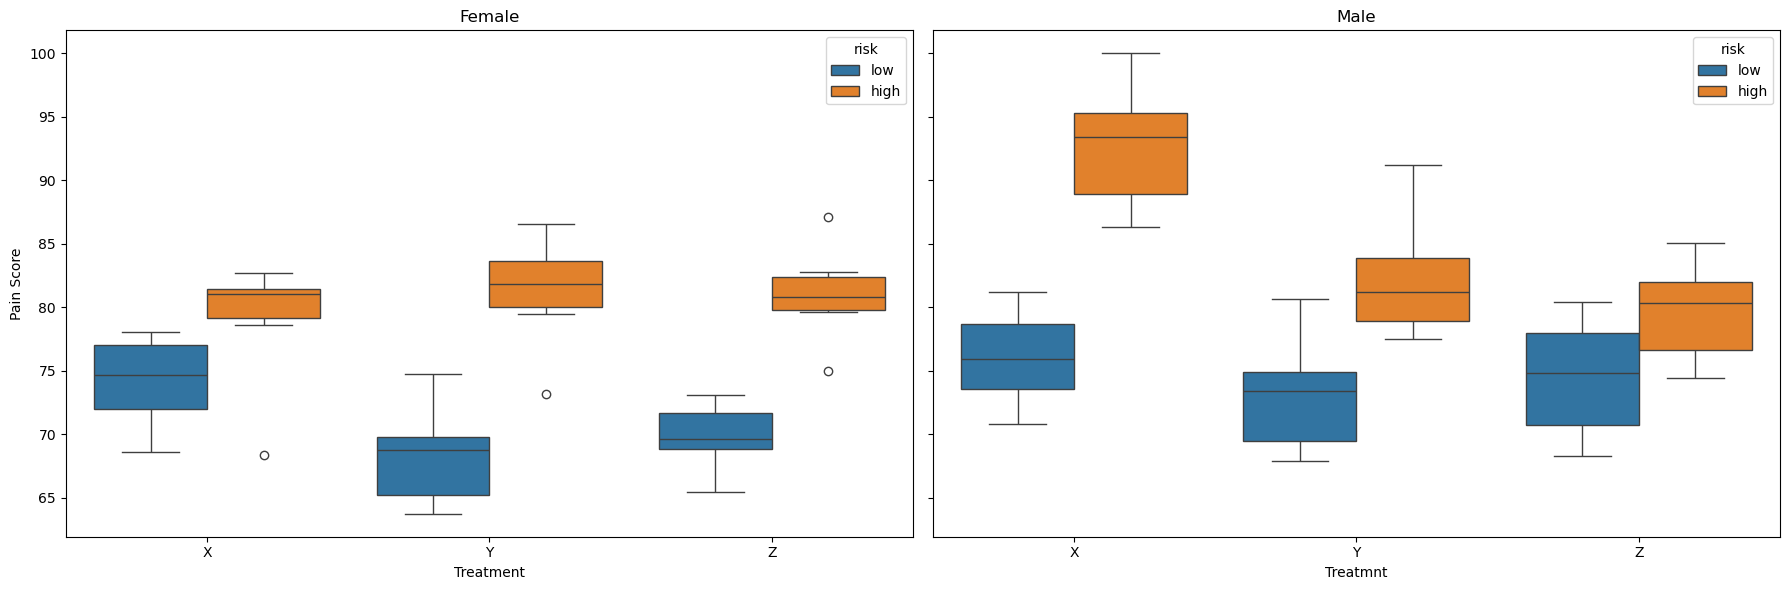

In [35]:

# create subplots for each age group
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# plot for female
sns.boxplot(x='treatment', y='pain_score', hue='risk', data=headache[headache['gender'] == 'female'], ax=axes[0])
axes[0].set_title('Female')
axes[0].set_xlabel('Treatment')
axes[0].set_ylabel('Pain Score')

# plot for male
sns.boxplot(x='treatment', y='pain_score', hue='risk', data=headache[headache['gender'] == 'male'], ax=axes[1])
axes[1].set_title('Male')
axes[1].set_xlabel('Treatmnt')
axes[1].set_ylabel('Pain Score')

plt.tight_layout()
plt.show()

Contingency table

In [41]:
# now, let's create the contingency table
contingency_table = pd.crosstab(index=[headache['gender'], headache['treatment']],
                                columns=headache['risk'],
                                values=headache['pain_score'],
                                aggfunc='count',
                                margins=True)
print(contingency_table)

risk              high  low  All
gender treatment                
female X             6    6   12
       Y             6    6   12
       Z             6    6   12
male   X             6    6   12
       Y             6    6   12
       Z             6    6   12
All                 36   36   72


Calculating mean and standard deviation for each group.

In [43]:
summary_stats = headache.groupby(['gender', 'risk', 'treatment'])['pain_score'].agg(['mean', 'std']).reset_index()
summary_stats.columns = ['gender', 'risk', 'treatment', 'mean_score', 'std_score']
print(summary_stats)

    gender  risk treatment  mean_score  std_score
0   female  high         X   78.865059   5.316489
1   female  high         Y   81.175304   4.619387
2   female  high         Z   81.035142   3.984886
3   female   low         X   74.156231   3.690272
4   female   low         Y   68.361925   4.081842
5   female   low         Z   69.779555   2.719645
6     male  high         X   92.738847   5.116095
7     male  high         Y   82.341542   5.000898
8     male  high         Z   79.680736   4.045885
9     male   low         X   76.051783   3.854876
10    male   low         Y   73.138772   4.765061
11    male   low         Z   74.455863   4.888865


## Assumtions


### Outliers

In [ ]:
# detect outlirs using IQR method
def detect_outliers_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data > upper_bound) | (data < lower_bound)]

outliers = headache.groupby(['gender', 'risk', 'treatment'])['pain_score'].apply(detect_outliers_iqr).reset_index()
print('The outliers are:')
print(outliers)

# remove outliers
headache_cleaned = headache.drop(outliers.index)
print('The data was cleaned from outliers.')


The outliers are:
   gender  risk treatment  level_3  pain_score
0  female  high         X       56   68.360185
1  female  high         Y       61   73.144392
2  female  high         Z       66   74.988057
3  female  high         Z       70   87.142265
The data was cleaned from outliers.


There are not many of them and they are not extreme.

### Normality

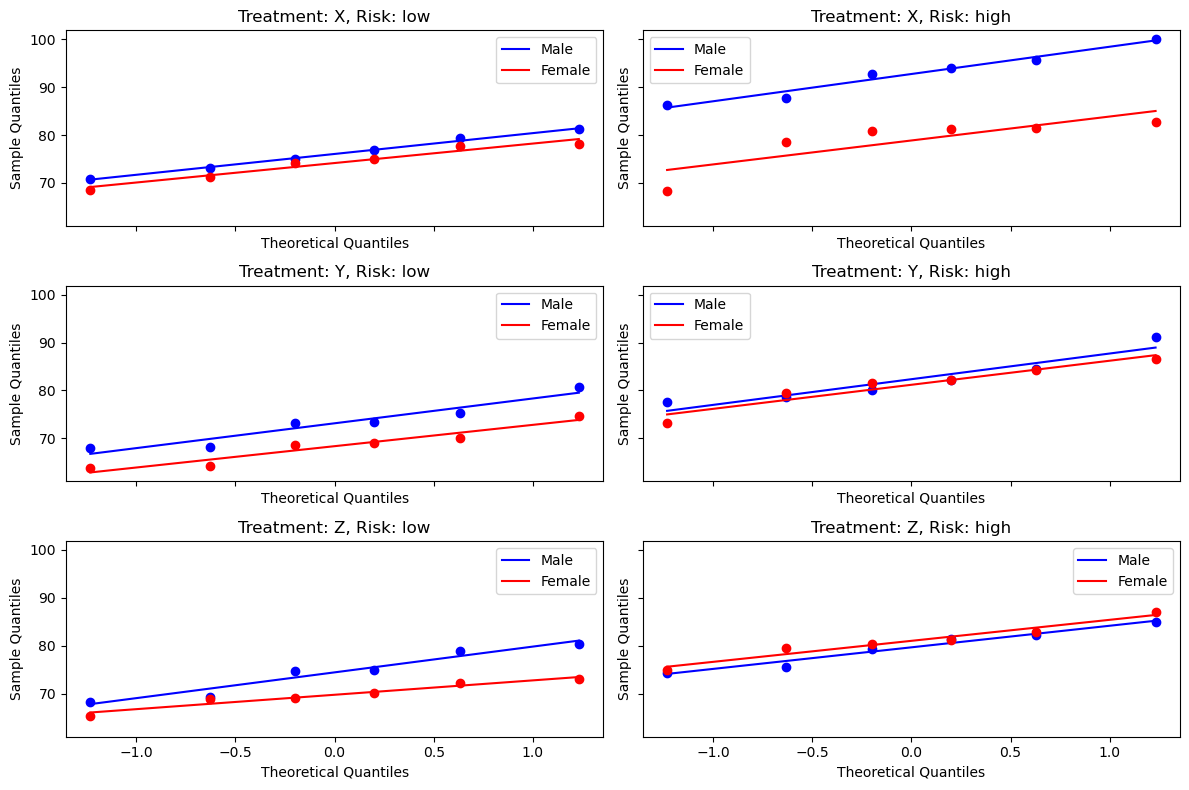

In [96]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# firstly, let's make a Q-Q plot

# Get unique values of treatment and risk
treatments = headache['treatment'].unique()
risks = headache['risk'].unique()

# Create subplots
fig, axes = plt.subplots(len(treatments), len(risks), figsize=(12, 8), sharex=True, sharey=True)

# Iterate over treatments and risks to create Q-Q plots
for i, treatment in enumerate(treatments):
    for j, risk in enumerate(risks):
        ax = axes[i, j]
        subset = headache[(headache['treatment'] == treatment) & (headache['risk'] == risk)]
        
        # Separate the data by gender
        male_data = subset[subset['gender'] == 'male']['pain_score']
        female_data = subset[subset['gender'] == 'female']['pain_score']
        
        # Q-Q plot for males
        if not male_data.empty:
            stats.probplot(male_data, dist="norm", plot=ax)
            ax.get_lines()[0].set_markerfacecolor('blue')
            ax.get_lines()[0].set_markeredgecolor('blue')
            ax.get_lines()[-1].set_color('blue')  # Set the color of the male Q-Q plot line
            ax.get_lines()[-1].set_label('Male')  # Set the label for the legend
        
        # Q-Q plot for females
        if not female_data.empty:
            stats.probplot(female_data, dist="norm", plot=ax)
            ax.get_lines()[2].set_markerfacecolor('red')
            ax.get_lines()[2].set_markeredgecolor('red')
            ax.get_lines()[-1].set_color('red')  # Set the color of the female Q-Q plot line
            ax.get_lines()[-1].set_label('Female')  # Set the label for the legend
        
        # Customize the subplot
        ax.set_title(f'Treatment: {treatment}, Risk: {risk}')
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Sample Quantiles')
        ax.legend()

plt.tight_layout()
plt.show()



The data looks normal, but check it also using the Shapiro-Wilk test.

In [97]:
def shapiro_wilk_test(data):
    stat, p = stats.shapiro(data)
    if p < 0.05:
        return pd.Series({'W': stat, 'p-value': p, 'Normality': 'Not Normal'})
    else:
        return pd.Series({'W': stat, 'p-value': p, 'Normality': 'Normal'})
    
shapiro_results = headache.groupby(['gender', 'risk', 'treatment'])['pain_score'].apply(shapiro_wilk_test).reset_index()
shapiro_results = shapiro_results.pivot(index=['gender', 'risk', 'treatment'], columns='level_3', values='pain_score').reset_index()
shapiro_results.columns.name = None

# Reorder columns to make 'Normality' the last column
cols = list(shapiro_results.columns)
cols.append(cols.pop(cols.index('Normality')))
shapiro_results = shapiro_results[cols]

print(shapiro_results)

    gender  risk treatment         W   p-value   Normality
0   female  high         X  0.714179   0.00869  Not Normal
1   female  high         Y  0.939332  0.653825      Normal
2   female  high         Z  0.971232  0.900605      Normal
3   female   low         X  0.932551  0.599938      Normal
4   female   low         Y  0.926774  0.555427      Normal
5   female   low         Z  0.957585  0.800947      Normal
6     male  high         X  0.958434  0.807596      Normal
7     male  high         Y   0.90173  0.384258      Normal
8     male  high         Z  0.955478  0.784302      Normal
9     male   low         X  0.982194  0.961928      Normal
10    male   low         Y  0.920272  0.507324      Normal
11    male   low         Z  0.924051  0.535006      Normal


Only the distribution for female with high risk and using X medice is not normal what is visible on the plot (upper left).

### Homogenity of variance

As the data is not normally distributed I will use the Levene's test.

In [101]:
grouped = headache.groupby(['risk', 'treatment', 'gender'])['pain_score'].apply(list)
stat, p_value = stats.levene(*grouped)
print(f"Levene's test statistic: {stat}")
print(f"p-value: {p_value}")

Levene's test statistic: 0.1785952808499546
p-value: 0.9982136500456728


The p-value is higher that 0.05 so there is no significant difference between variances.

### ANOVA

I will use a rank-based ANOVA as there were problems with normality of the data.

In [130]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
# perform the rank-based anova
headache['ranked_pain_score'] = stats.rankdata(headache['pain_score'])
headache['interaction'] = headache['risk'] + "_" + headache['treatment'] + "_" + headache['gender']

# fit an ANOVA model on the ranked data
formula = 'ranked_pain_score ~ risk * treatment * gender'
model = ols(formula, data=headache).fit()

anova_results = anova_lm(model, typ=2)
pd.options.display.float_format = '{:.3f}'.format

print(anova_results)
#pd.reset_option('display.float_format')


                         sum_sq     df      F  PR(>F)
risk                  15901.389  1.000 89.717   0.000
treatment              1225.333  2.000  3.457   0.038
gender                 1530.889  1.000  8.637   0.005
risk:treatment          177.778  2.000  0.502   0.608
risk:gender              53.389  1.000  0.301   0.585
treatment:gender        438.111  2.000  1.236   0.298
risk:treatment:gender  1136.778  2.000  3.207   0.048
Residual              10634.333 60.000    NaN     NaN


### Interpretation

The p-value for all: risk, treatment and gender is less than 0.05, so all these factors have impact on the pain score. Hovewer, the 3 factors do not have impact on each other in pairs (risk with treatment, risk with gender and gender with treatment). The p-value for interaction between risk, treatment and gender is really close to 0.05, but I assumend that, there is significant impact between these 3 factors.

## Post-hoc tests

### Two-way interactions

The third variable is gender


In [131]:
male_data = headache[headache['gender'] == 'male']
female_data = headache[headache['gender'] == 'female']

# two-way ANOVA for males
print("Two-Way ANOVA for Males:")
model_male = ols('ranked_pain_score ~ risk * treatment', data=male_data).fit()
anova_male = anova_lm(model_male, typ=2)
print(anova_male)

# t-way ANOVA for females
print("\nTwo-Way ANOVA for Females:")
model_female = ols('ranked_pain_score ~ risk * treatment', data=female_data).fit()
anova_female = anova_lm(model_female, typ=2)
print(anova_female)

Two-Way ANOVA for Males:
                 sum_sq     df      F  PR(>F)
risk           7056.000  1.000 38.757   0.000
treatment      1559.722  2.000  4.284   0.023
risk:treatment  506.167  2.000  1.390   0.265
Residual       5461.667 30.000    NaN     NaN

Two-Way ANOVA for Females:
                 sum_sq     df      F  PR(>F)
risk           8898.778  1.000 51.610   0.000
treatment       103.722  2.000  0.301   0.742
risk:treatment  808.389  2.000  2.344   0.113
Residual       5172.667 30.000    NaN     NaN


For males risk and treatment has significant effect on ranked pain scores.

For females only risk has significant effect on the ranked pain score.

For both genders, there is no evidence that there is an interaction between risk and treatment.

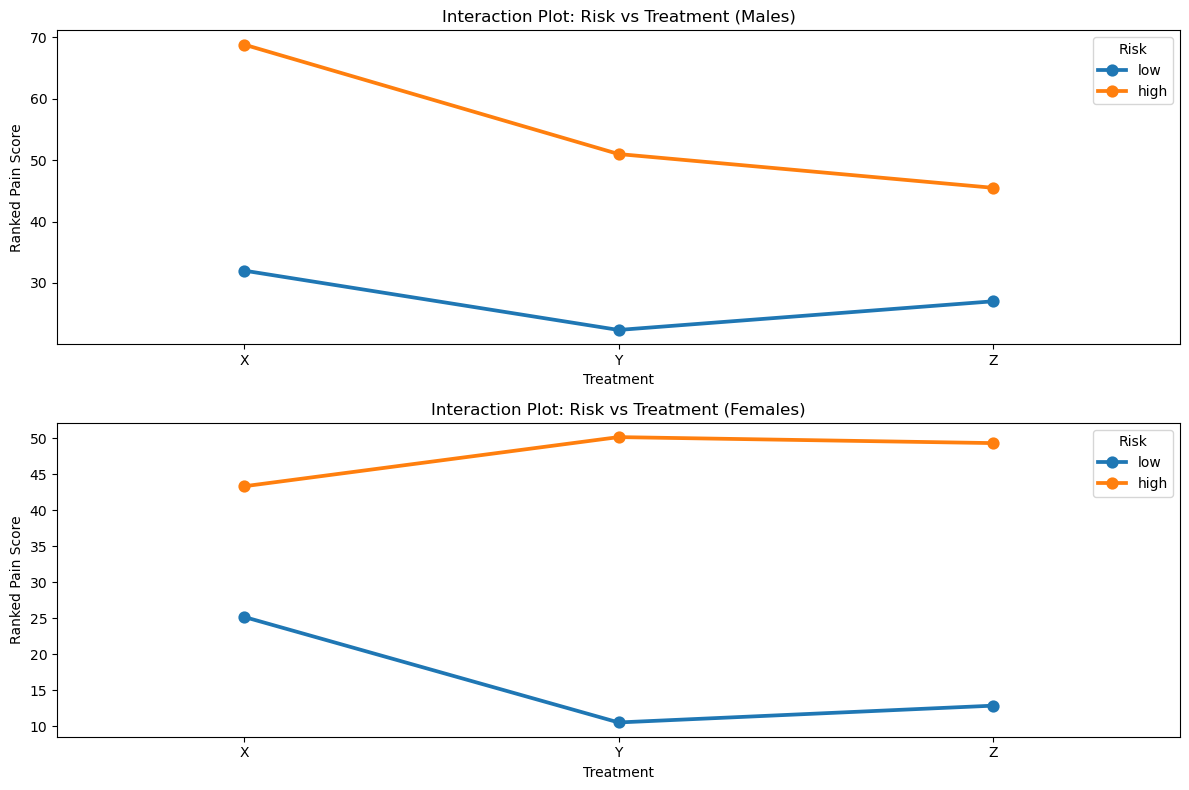

In [137]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
# Interaction plot for males
sns.pointplot(data=male_data, x='treatment', y='ranked_pain_score', hue='risk', errorbar=None, ax=axes[0])
axes[0].set_title('Interaction Plot: Risk vs Treatment (Males)')
axes[0].set_ylabel('Ranked Pain Score')
axes[0].set_xlabel('Treatment')
axes[0].legend(title='Risk')

# Interaction plot for females
sns.pointplot(data=female_data, x='treatment', y='ranked_pain_score', hue='risk', errorbar=None, ax=axes[1])
axes[1].set_title('Interaction Plot: Risk vs Treatment (Females)')
axes[1].set_ylabel('Ranked Pain Score')
axes[1].set_xlabel('Treatment')
axes[1].legend(title='Risk')

plt.tight_layout()
plt.show()

For both genders higher risk results in higher ranked pain score.

For males: 
For high risk group, treatment X results in highest ranked pain score and treatment Z - in lowest.
For low risk group, again, treatment X results in highest ranked pain scores, but this time treatment Y has lowest scores.

For females:
The situation looks exactly opposite for two risk groups.
Treatment X has lowest scores in high risk group and the highest scores for low risk group.
Treatments Y and Z has simmilar results compared to each other, but higher than X for high risk group and lower than X, for low risk group.

### Main effects

The second variable is treatment, so I test the effect of risk at each level of treatment

In [147]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

treatments = headache['treatment'].unique()

for treatment in treatments:
    print(f"\nSimple Main Effect: Risk at Treatment - {treatment}")
    subset = headache[headache['treatment'] == treatment]
    
    model = ols('ranked_pain_score ~ risk', data=subset).fit()
    anova_table = anova_lm(model, typ=2)
    print(anova_table)


Simple Main Effect: Risk at Treatment - X
           sum_sq     df      F  PR(>F)
risk     4537.500  1.000 18.680   0.000
Residual 5343.833 22.000    NaN     NaN

Simple Main Effect: Risk at Treatment - Y
           sum_sq     df      F  PR(>F)
risk     7004.167  1.000 34.381   0.000
Residual 4481.833 22.000    NaN     NaN

Simple Main Effect: Risk at Treatment - Z
           sum_sq     df      F  PR(>F)
risk     4537.500  1.000 25.159   0.000
Residual 3967.833 22.000    NaN     NaN


In all cases, the p-value is lower than 0.05, so the difference between low risk and high risk is consistently significant, regardless of the treatment type. We can also observe it on the plots above that, high risk always results in higher scores. This suggests that the impact of risk on pain scores might vary slightly in strength depending on the treatment.

Now, I will analyze the effect of treatment on each level of risk (the other way around).

In [146]:
risks = headache['risk'].unique()

for risk in risks:
    print(f"\nSimple Main Effect: Treatment at Risk Level - {risk}")
    subset = headache[headache['risk'] == risk]
    
    model = ols('ranked_pain_score ~ treatment', data=subset).fit()
    anova_table = anova_lm(model, typ=2)
    print(anova_table)


Simple Main Effect: Treatment at Risk Level - low
            sum_sq     df     F  PR(>F)
treatment  941.556  2.000 2.678   0.084
Residual  5800.750 33.000   NaN     NaN

Simple Main Effect: Treatment at Risk Level - high
            sum_sq     df     F  PR(>F)
treatment  461.556  2.000 0.953   0.396
Residual  7992.750 33.000   NaN     NaN


In both cases p-value is higher than 0.05, so the type of treatment does not have significant effect on the scores (for low risk and for high risk).

C:\Users\malwi\AppData\Local\Temp\ipykernel_14924\1052315830.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='treatment', y='ranked_pain_score', errorbar=None, palette='muted')
C:\Users\malwi\AppData\Local\Temp\ipykernel_14924\1052315830.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='treatment', y='ranked_pain_score', errorbar=None, palette='muted')


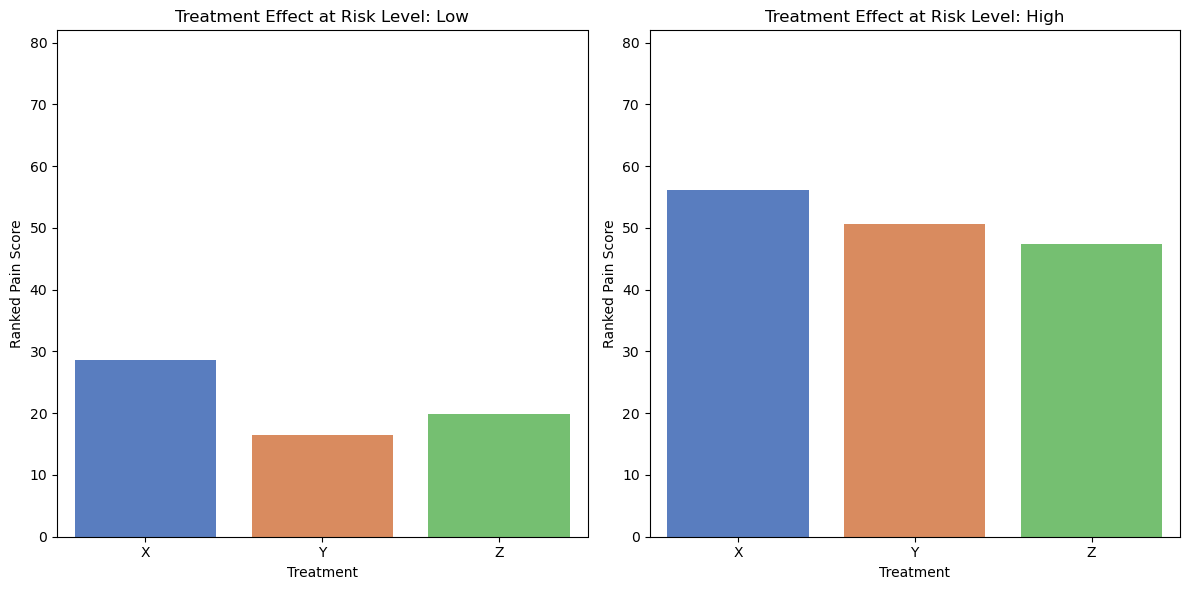

In [151]:
plt.figure(figsize=(12, 6))

for i, risk in enumerate(risks):
    plt.subplot(1, 2, i + 1)
    subset = headache[headache['risk'] == risk]
    sns.barplot(data=subset, x='treatment', y='ranked_pain_score', errorbar=None, palette='muted')
    plt.title(f"Treatment Effect at Risk Level: {risk.capitalize()}")
    plt.ylabel("Ranked Pain Score")
    plt.xlabel("Treatment")
    plt.ylim(0, headache['ranked_pain_score'].max() + 10)

plt.tight_layout()
plt.show()

We can observe that, treatment type does not have a statistically significant effect on ranked pain scores within either risk level (low or high). Treatment X on plots apears to have higher scores, but this difference is not statistically significant.

### Pairwise comparisons

Firstly, I compute the Tukey's HSD test for the main effect of risk.

In [157]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Tukey's HSD for the main effect of risk
tukey_risk = pairwise_tukeyhsd(endog=headache['ranked_pain_score'], 
                               groups=headache['risk'], 
                               alpha=0.05)
print("Tukey HSD for Risk:")
print(tukey_risk)

Tukey HSD for Risk:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
  high    low -29.7222   0.0 -36.6486 -22.7958   True
-----------------------------------------------------


Here we can see again that the difference between high and low risk is significant. the p-adj is smaller than 0.05 and the mean difference is also huge - (-29.72) between both groups.


Tukey HSD for Treatment at Risk Level - Low
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     X      Y -12.1667 0.0779 -25.4482  1.1148  False
     X      Z  -8.6667 0.2594 -21.9482  4.6148  False
     Y      Z      3.5 0.7955  -9.7815 16.7815  False
-----------------------------------------------------


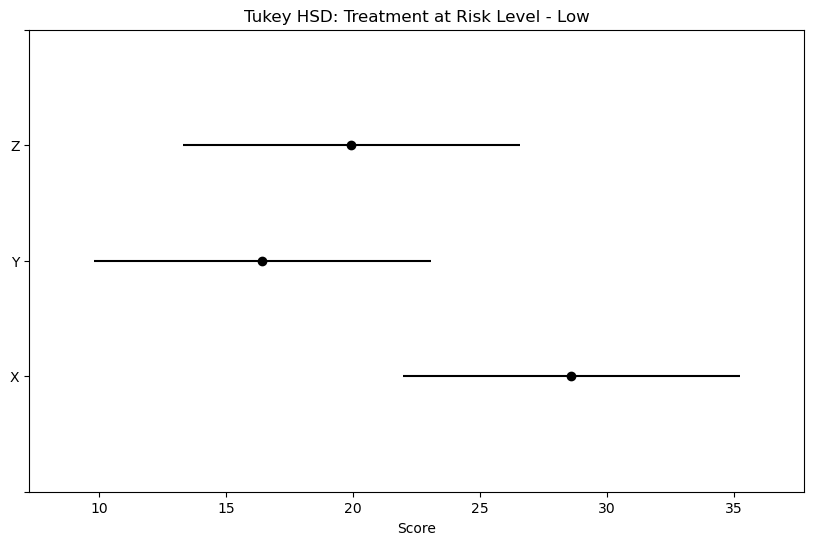


Tukey HSD for Treatment at Risk Level - High
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     X      Y     -5.5 0.6654 -21.0903 10.0903  False
     X      Z  -8.6667  0.371 -24.2569  6.9236  False
     Y      Z  -3.1667 0.8726 -18.7569 12.4236  False
-----------------------------------------------------


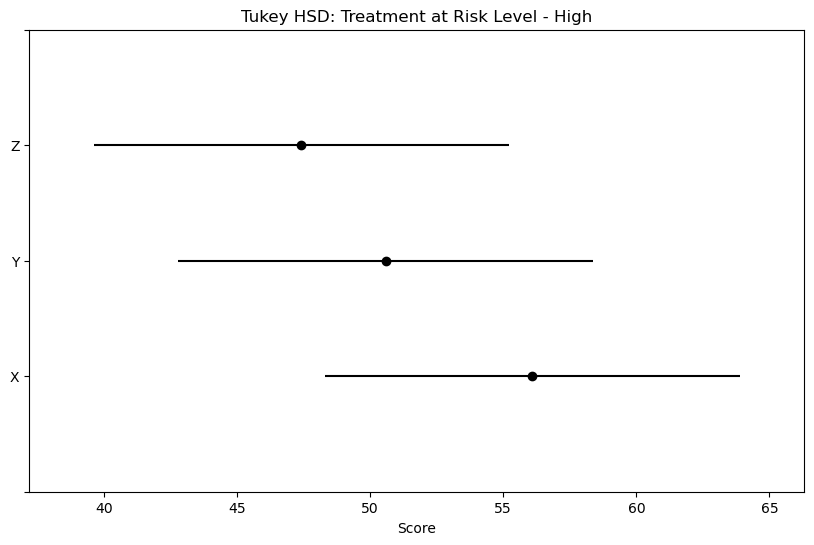

In [159]:
# Tukey's HSD for treatment at each level of risk
risk_levels = ['low', 'high']

for risk in risk_levels:
    print(f"\nTukey HSD for Treatment at Risk Level - {risk.capitalize()}")
    subset = headache[headache['risk'] == risk]
    tukey_treatment = pairwise_tukeyhsd(endog=subset['ranked_pain_score'], 
                                        groups=subset['treatment'], 
                                        alpha=0.05)
    print(tukey_treatment)

    tukey_treatment.plot_simultaneous()
    plt.title(f"Tukey HSD: Treatment at Risk Level - {risk.capitalize()}")
    plt.xlabel('Score')
    plt.show()

In both risk groups, we see "False" in "reject" column, which indicated that we should reject the null hypothesis cannot be rejected. In this case, the null hypothesis says that here is no signigicant difference between the different types of treatment. On the plots, we can see that there is a lot of overlap between the ranges of scores, which only confirms the earlier calculations.